In [21]:
import os
#go back one directory
os.chdir("..")
# # now go into source directory
# os.chdir("source")

In [22]:
sat_list = {
    'TerraSAR-X': {
        'norad_id': 31698,
        'sp3-c_code':"L13",
        'mass': 1230.0,          
        'cross_section': 4,  
        'cd': 2.2,             
        'cr': 1.5
    },
    'GRACE-FO -A': {
        'norad_id': 43476,
        'sp3-c_code':"L64",
        'mass': 600.2,          
        'cross_section': 3.123,
        'cd': 2.2,             
        'cr': 1.5  
    },
    'GRACE-FO -B': {
        'norad_id': 43477,
        'sp3-c_code':"L65",
        'mass': 600.2,          
        'cross_section': 3.123,
        'cd': 2.2,             
        'cr': 1.5  
    },
    'TanDEM-X': {
    'norad_id': 36605,
    'sp3-c_code':"L20",
    'mass': 1350.0,          
    'cross_section': 5,  
    'cd': 2.2,             
    'cr': 1.5
    },
}

In [43]:
import pandas as pd
import sp3
import gzip
import tempfile
import os

def read_sp3_gz_file(sp3_gz_file_path):
    # Create a temporary file to store the uncompressed data
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.sp3')
    temp_file_path = temp_file.name

    # Uncompress the .sp3.gz file and write to the temporary file
    with gzip.open(sp3_gz_file_path, 'rb') as gz_file:
        temp_file.write(gz_file.read())
    temp_file.close()

    # Load SP3 file
    product = sp3.Product.from_file(temp_file_path)

    # Assuming to use the first satellite in the file
    satellite = product.satellites[0]

    # Extracting records
    records = satellite.records

    # Preparing lists to store data
    times = []
    positions = []
    velocities = []

    # Loop through each record and extract data
    for record in records:
        times.append(record.time)
        positions.append(record.position)
        velocities.append(record.velocity if record.velocity else (None, None, None))

    # Creating a DataFrame
    df = pd.DataFrame({
        'Time': times,
        'Position_X': [pos[0] for pos in positions],
        'Position_Y': [pos[1] for pos in positions],
        'Position_Z': [pos[2] for pos in positions],
        'Velocity_X': [vel[0] for vel in velocities],
        'Velocity_Y': [vel[1] for vel in velocities],
        'Velocity_Z': [vel[2] for vel in velocities]
    })

    # Clean up temporary file
    os.remove(temp_file_path)

    return df

# Example usage
sp3_gz_file_path = 'notebooks/sp3_cache/GFZOP_RSO_L65_G_20230504_220000_20230505_120000_v02.sp3.gz'
df = read_sp3_gz_file(sp3_gz_file_path)
print(df.head())

                       Time   Position_X  Position_Y   Position_Z  \
0 2023-05-04 21:59:42+00:00  2259132.749 -589527.477 -6459887.886   
1 2023-05-04 22:00:12+00:00  2052366.384 -528156.872 -6534063.516   
2 2023-05-04 22:00:42+00:00  1843621.454 -465298.116 -6601023.225   
3 2023-05-04 22:01:12+00:00  1633133.746 -401012.117 -6660694.886   
4 2023-05-04 22:01:42+00:00  1421140.554 -335362.345 -6713014.377   

    Velocity_X   Velocity_Y   Velocity_Z  
0 -6856.630545  2020.229352 -2591.918762  
1 -6926.493544  2070.820487 -2352.678467  
2 -6988.525047  2119.424796 -2110.901374  
3 -7042.670363  2165.955812 -1866.853102  
4 -7088.883856  2210.329179 -1620.801518  


In [44]:
import pandas as pd
import sp3
import gzip
import tempfile
import os
import glob

sat_list = {
    'TerraSAR-X': {'sp3-c_code':"L13"},
    'GRACE-FO -A': {'sp3-c_code':"L64"},
    'GRACE-FO -B': {'sp3-c_code':"L65"},
    'TanDEM-X': {'sp3-c_code':"L20"}
}

def read_sp3_gz_file(sp3_gz_file_path):
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.sp3')
    temp_file_path = temp_file.name

    with gzip.open(sp3_gz_file_path, 'rb') as gz_file:
        temp_file.write(gz_file.read())
    temp_file.close()

    product = sp3.Product.from_file(temp_file_path)
    satellite = product.satellites[0]
    records = satellite.records

    times = []
    positions = []
    velocities = []

    for record in records:
        times.append(record.time)
        positions.append(record.position)
        velocities.append(record.velocity if record.velocity else (None, None, None))

    df = pd.DataFrame({
        'Time': times,
        'Position_X': [pos[0] for pos in positions],
        'Position_Y': [pos[1] for pos in positions],
        'Position_Z': [pos[2] for pos in positions],
        'Velocity_X': [vel[0] for vel in velocities],
        'Velocity_Y': [vel[1] for vel in velocities],
        'Velocity_Z': [vel[2] for vel in velocities]
    })

    os.remove(temp_file_path)
    return df

def process_sp3_files(base_path, sat_list):
    all_dataframes = {}

    for sat_name, sat_info in sat_list.items():
        sp3_c_code = sat_info['sp3-c_code']
        satellite_path = os.path.join(base_path, sp3_c_code)
        for day_folder in glob.glob(f"{satellite_path}/*"):
            for sp3_gz_file in glob.glob(f"{day_folder}/*.sp3.gz"):
                df = read_sp3_gz_file(sp3_gz_file)
                all_dataframes[(sat_name, os.path.basename(sp3_gz_file))] = df

    return all_dataframes

# Specify the base path to your sp3_cache folder
base_path = 'notebooks/sp3_cache'
dataframes = process_sp3_files(base_path, sat_list)

# Example of accessing a specific dataframe
sat_name = 'GRACE-FO-B'
sp3_file = 'GFZOP_RSO_L65_G_20230504_220000_20230505_120000_v02.sp3.gz'
print(dataframes[(sat_name, sp3_file)].head())


                       Time   Position_X  Position_Y   Position_Z  \
0 2023-05-04 21:59:42+00:00  2259132.749 -589527.477 -6459887.886   
1 2023-05-04 22:00:12+00:00  2052366.384 -528156.872 -6534063.516   
2 2023-05-04 22:00:42+00:00  1843621.454 -465298.116 -6601023.225   
3 2023-05-04 22:01:12+00:00  1633133.746 -401012.117 -6660694.886   
4 2023-05-04 22:01:42+00:00  1421140.554 -335362.345 -6713014.377   

    Velocity_X   Velocity_Y   Velocity_Z  
0 -6856.630545  2020.229352 -2591.918762  
1 -6926.493544  2070.820487 -2352.678467  
2 -6988.525047  2119.424796 -2110.901374  
3 -7042.670363  2165.955812 -1866.853102  
4 -7088.883856  2210.329179 -1620.801518  


In [45]:
# Example of accessing a specific dataframe
sat_name = 'GRACE-FO-B'
sp3_file = 'GFZOP_RSO_L65_G_20230504_220000_20230505_120000_v02.sp3.gz'
print(dataframes[(sat_name, sp3_file)].tail())

                          Time   Position_X   Position_Y   Position_Z  \
1677 2023-05-05 11:58:12+00:00 -4170661.582  4501985.803 -3072900.241   
1678 2023-05-05 11:58:42+00:00 -4092542.507  4430454.729 -3275728.037   
1679 2023-05-05 11:59:12+00:00 -4010228.187  4353679.623 -3474912.098   
1680 2023-05-05 11:59:42+00:00 -3923833.688  4271728.650 -3670232.070   
1681 2023-05-05 12:00:12+00:00 -3833478.244  4184676.188 -3861472.059   

       Velocity_X   Velocity_Y   Velocity_Z  
1677  2532.805783 -2296.263478 -6819.171458  
1678  2674.517316 -2472.130977 -6701.433813  
1679  2812.464675 -2645.830676 -6576.279283  
1680  2946.506097 -2817.154269 -6443.852603  
1681  3076.505391 -2985.895849 -6304.306661  


In [46]:
# Example of accessing a specific dataframe
sat_name = 'GRACE-FO-B'
sp3_file = 'GFZOP_RSO_L65_G_20230505_100000_20230506_000000_v02.sp3.gz'
print(dataframes[(sat_name, sp3_file)].head())

                       Time   Position_X   Position_Y   Position_Z  \
0 2023-05-05 09:59:42+00:00 -2681103.620   985182.710  6234127.618   
1 2023-05-05 10:00:12+00:00 -2875566.836  1053491.510  6135403.206   
2 2023-05-05 10:00:42+00:00 -3066560.096  1121481.545  6029862.871   
3 2023-05-05 10:01:12+00:00 -3253873.540  1189061.905  5917622.326   
4 2023-05-05 10:01:42+00:00 -3437301.662  1256141.185  5798804.778   

    Velocity_X   Velocity_Y   Velocity_Z  
0 -6537.573293  2281.267520 -3175.992440  
1 -6425.452199  2272.150744 -3405.034315  
2 -6306.265798  2260.013153 -3630.345133  
3 -6180.155310  2244.836301 -3851.673275  
4 -6047.269766  2226.605749 -4068.771206  


In [53]:
import pandas as pd
import sp3
import gzip
import tempfile
import os
import glob

sat_list = {
    'TerraSAR-X': {'sp3-c_code':"L13"},
    'GRACE-FO-A': {'sp3-c_code':"L64"},
    'GRACE-FO-B': {'sp3-c_code':"L65"},
    'TanDEM-X': {'sp3-c_code':"L20"}
}

def read_sp3_gz_file(sp3_gz_file_path):
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.sp3')
    temp_file_path = temp_file.name

    with gzip.open(sp3_gz_file_path, 'rb') as gz_file:
        temp_file.write(gz_file.read())
    temp_file.close()

    product = sp3.Product.from_file(temp_file_path)
    satellite = product.satellites[0]
    records = satellite.records

    times = []
    positions = []
    velocities = []

    for record in records:
        times.append(record.time)
        positions.append(record.position)
        velocities.append(record.velocity if record.velocity else (None, None, None))

    df = pd.DataFrame({
        'Time': times,
        'Position_X': [pos[0] for pos in positions],
        'Position_Y': [pos[1] for pos in positions],
        'Position_Z': [pos[2] for pos in positions],
        'Velocity_X': [vel[0] for vel in velocities],
        'Velocity_Y': [vel[1] for vel in velocities],
        'Velocity_Z': [vel[2] for vel in velocities]
    })

    os.remove(temp_file_path)
    return df

def process_sp3_files(base_path, sat_list):
    all_dataframes = {sat_name: [] for sat_name in sat_list}

    for sat_name, sat_info in sat_list.items():
        sp3_c_code = sat_info['sp3-c_code']
        satellite_path = os.path.join(base_path, sp3_c_code)
        for day_folder in glob.glob(f"{satellite_path}/*"):
            for sp3_gz_file in glob.glob(f"{day_folder}/*.sp3.gz"):
                df = read_sp3_gz_file(sp3_gz_file)
                all_dataframes[sat_name].append(df)

    # Concatenating dataframes for each spacecraft
    concatenated_dataframes = {}
    for sat_name, dfs in all_dataframes.items():
        concatenated_df = pd.concat(dfs).drop_duplicates(subset='Time').set_index('Time').sort_index()
        
        # Checking for consistent time intervals (30 seconds), ignoring NaN values
        time_diffs = concatenated_df.index.to_series().diff().dt.total_seconds()
        if not time_diffs[time_diffs.notna()].eq(30).all():
            print(f"found a time interval of {time_diffs[time_diffs.notna()].unique()} seconds in data for {sat_name}")
            raise ValueError(f"Inconsistent time intervals found in data for {sat_name}")

        concatenated_dataframes[sat_name] = concatenated_df

    return concatenated_dataframes

# Specify the base path to your sp3_cache folder
base_path = 'notebooks/sp3_cache'
concatenated_dfs = process_sp3_files(base_path, sat_list)


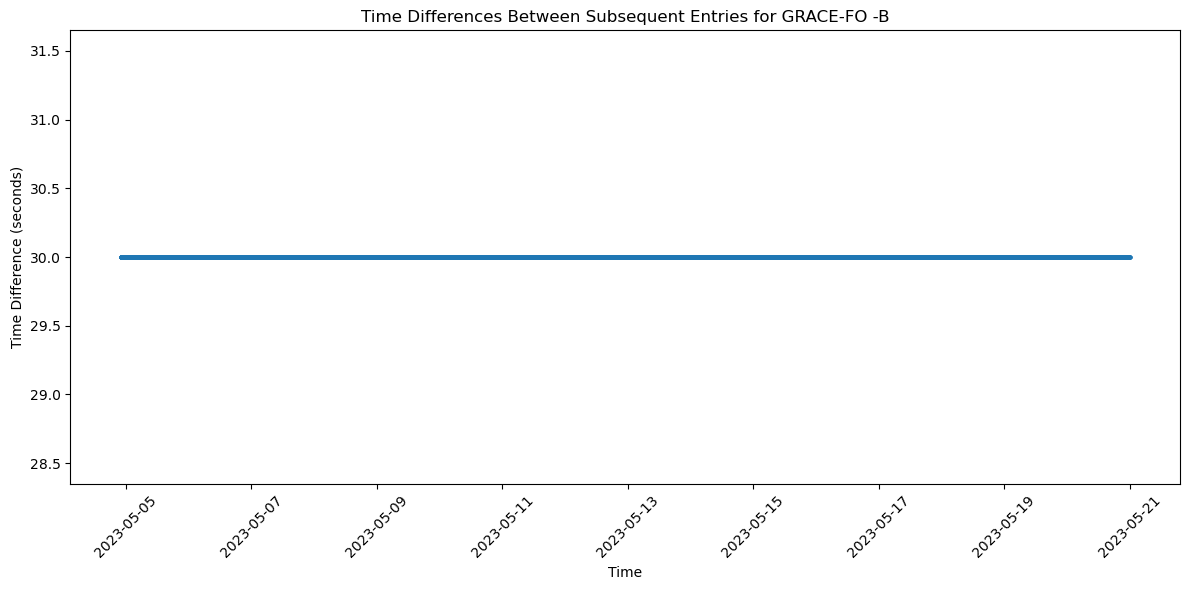

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'concatenated_dfs' contains the concatenated DataFrame for 'GRACE-FO -B'
grace_fo_b_df = concatenated_dfs['GRACE-FO -B']

# Convert the index to pandas datetime
grace_fo_b_df.index = pd.to_datetime(grace_fo_b_df.index)

# Calculating the difference in time between each entry
time_diffs = grace_fo_b_df.index.to_series().diff().dt.total_seconds()[1:]

# Plotting the time differences
plt.figure(figsize=(12, 6))
plt.plot(grace_fo_b_df.index[1:], time_diffs, marker='o', linestyle='-', markersize=2)
plt.xlabel('Time')
plt.ylabel('Time Difference (seconds)')
plt.title('Time Differences Between Subsequent Entries for GRACE-FO -B')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


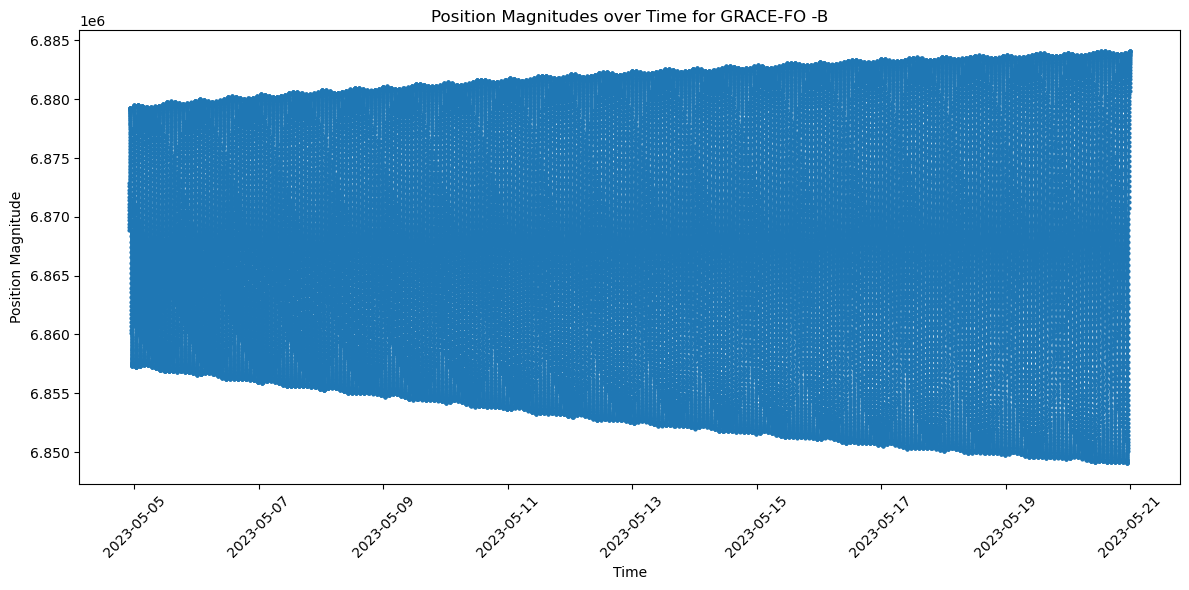

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'concatenated_dfs' contains the concatenated DataFrame for 'GRACE-FO -B'
grace_fo_b_df = concatenated_dfs['GRACE-FO -B']

# Calculating the Euclidean norm (magnitude) of the position vectors
position_magnitudes = np.linalg.norm(grace_fo_b_df[['Position_X', 'Position_Y', 'Position_Z']].values, axis=1)

# Plotting the position magnitudes over time
plt.figure(figsize=(12, 6))
plt.plot(grace_fo_b_df.index, position_magnitudes, marker='o', linestyle='-', markersize=2)
plt.xlabel('Time')
plt.ylabel('Position Magnitude')
plt.title('Position Magnitudes over Time for GRACE-FO -B')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


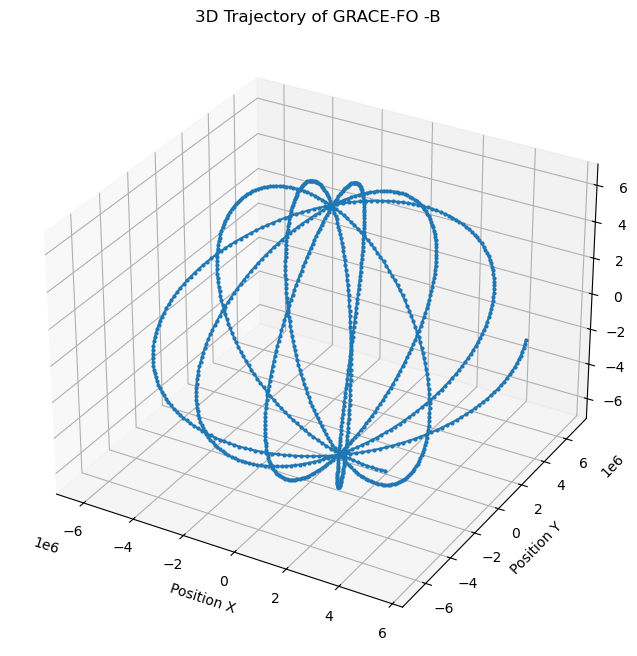

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'concatenated_dfs' contains the concatenated DataFrame for 'GRACE-FO -B'
grace_fo_b_df = concatenated_dfs['GRACE-FO -B']

# Extracting the X, Y, Z coordinates
x = grace_fo_b_df['Position_X'].iloc[:1000]
y = grace_fo_b_df['Position_Y'].iloc[:1000]
z = grace_fo_b_df['Position_Z'].iloc[:1000]

# Creating a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the X, Y, Z coordinates
ax.plot(x, y, z, marker='o', linestyle='-', markersize=2)

ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_zlabel('Position Z')
ax.set_title('3D Trajectory of GRACE-FO -B')

plt.show()


In [ ]:

from astropy.coordinates import GCRS, ITRS, CartesianRepresentation, CartesianDifferential, SkyCoord, GCRS, CIRS, TEME, TETE, ITRS, ICRS
from astropy.time import Time
from astropy import units as u

def eci2ecef_astropy(eci_pos: np.ndarray, eci_vel: np.ndarray, mjd: float):
    """
    Convert ECI (Earth-Centered Inertial) coordinates to ECEF (Earth-Centered, Earth-Fixed) coordinates using Astropy.

    Parameters
    ----------
    eci_pos : np.ndarray
        ECI position vectors.
    eci_vel : np.ndarray
        ECI velocity vectors.
    mjd : float
        Modified Julian Date.

    Returns
    -------
    tuple
        ECEF position vectors and ECEF velocity vectors.
    """
    # Convert MJD to isot format for Astropy
    time_utc = Time(mjd, format="mjd", scale='utc')

    # Convert ECI position and velocity to ECEF coordinates using Astropy
    eci_cartesian = CartesianRepresentation(eci_pos.T * u.km)
    eci_velocity = CartesianDifferential(eci_vel.T * u.km / u.s)
    gcrs_coords = GCRS(eci_cartesian.with_differentials(eci_velocity), obstime=time_utc)
    itrs_coords = gcrs_coords.transform_to(ITRS(obstime=time_utc))

    # Get ECEF position and velocity from Astropy coordinates
    ecef_pos = np.column_stack((itrs_coords.x.value, itrs_coords.y.value, itrs_coords.z.value))
    ecef_vel = np.column_stack((itrs_coords.v_x.value, itrs_coords.v_y.value, itrs_coords.v_z.value))

    return ecef_pos, ecef_vel